In [1]:
# ! pip install torch_geometric
# ! pip install networkx

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_dense_adj, to_networkx
import torch_geometric.nn as gnn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Zachary’s Karate Club overview

In [3]:
dataset = KarateClub()
print(dataset.get_summary())
print(f'Num of node features: {dataset.num_node_features}')
print(f'Num of classes: {dataset.num_classes}')

data = dataset[0]
print(f'Is directed: {data.is_directed()}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')

KarateClub (#graphs=1):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |       34 |      156 |
| std        |      nan |      nan |
| min        |       34 |      156 |
| quantile25 |       34 |      156 |
| median     |       34 |      156 |
| quantile75 |       34 |      156 |
| max        |       34 |      156 |
+------------+----------+----------+
Num of node features: 34
Num of classes: 4
Is directed: False
Has isolated nodes: False
Has self loops: False


In [4]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [5]:
# Here, the node feature matrix x is an identity matrix:
# it doesn’t contain any relevant information about the nodes.
# It could contain information like age, skill level, etc.
# but this is not the case in this dataset.
# It means we’ll have to classify our nodes just by looking at
# their connections.
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [6]:
# connections between nodes (edges)
data.edge_index[:, :10].T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11]])

In [7]:
# classes
data.y[:10]

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1])

In [8]:
# mask for nodes in training dataset
data.train_mask[:10]

tensor([ True, False, False, False,  True, False, False, False,  True, False])

In [9]:
# get adjacency matrix from COO format
to_dense_adj(data.edge_index).numpy().astype(int)

array([[[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0]]])

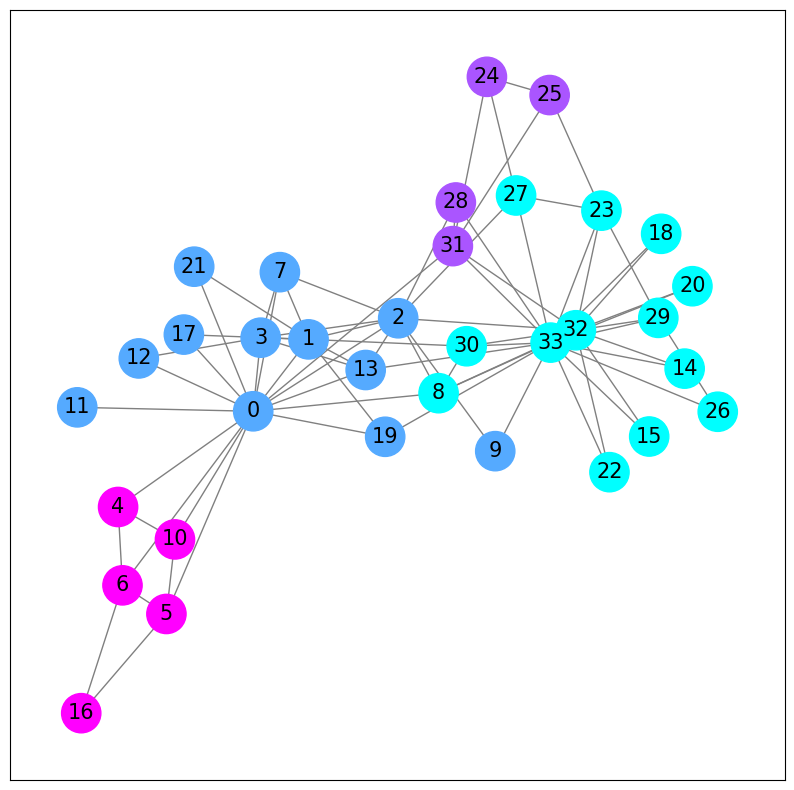

In [10]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=2010),
    node_size=800,
    node_color=data.y,
    cmap='cool',
    edge_color='grey',
    font_size=15
)

## Implementing a Graph Convolutional Network (GCN)

### Defining a model

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gcn = gnn.GCNConv(input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index):
        embeds = self.gcn(x, edge_index).relu()
        out = self.lin(embeds)
        return embeds, out
    
    def train(self, x, edge_index, optimizer, crit, num_epochs,
              display_freq=None, return_more_info=False):
        
        losses, accuracies, preds = [], [], []
        embeds = torch.Tensor(x.size()[0], self.hidden_size)

        for epoch in range(num_epochs):
            optimizer.zero_grad()

            embeds, outputs = self(x, edge_index)
            y_pred = outputs.argmax(dim=1)

            loss = crit(outputs, data.y)
            acc = self.__accuracy__(y_pred, data.y)

            loss.backward()
            optimizer.step()

            losses.append(loss)    
            accuracies.append(acc)
            preds.append(y_pred)

            if display_freq and (epoch + 1) % display_freq == 0:
                print('Epoch %d: loss: %.2f, acc: %.2f' %\
                    (epoch + 1, loss, acc))

        if return_more_info:
            return embeds, losses, accuracies, preds
        
        return losses, accuracies
        
    def __accuracy__(self, y_pred, y):
        return (y_pred == y).sum() / len(y)
    
GCN(dataset.num_features, 3, dataset.num_classes)

GCN(
  (gcn): GCNConv(34, 3)
  (lin): Linear(in_features=3, out_features=4, bias=True)
)

### Training

In [12]:
model = GCN(dataset.num_features, 3, dataset.num_classes)
crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

num_epochs = 300
display_freq = 10

embeddings, losses, accuracies, preds = model.train(
    data.x, data.edge_index,
    optimizer, crit, num_epochs,
    display_freq, return_more_info=True
)

Epoch 10: loss: 1.30, acc: 0.35
Epoch 20: loss: 1.26, acc: 0.41
Epoch 30: loss: 1.22, acc: 0.50
Epoch 40: loss: 1.17, acc: 0.68
Epoch 50: loss: 1.12, acc: 0.71
Epoch 60: loss: 1.05, acc: 0.71
Epoch 70: loss: 0.98, acc: 0.71
Epoch 80: loss: 0.90, acc: 0.71
Epoch 90: loss: 0.82, acc: 0.74
Epoch 100: loss: 0.74, acc: 0.74
Epoch 110: loss: 0.67, acc: 0.74
Epoch 120: loss: 0.60, acc: 0.82
Epoch 130: loss: 0.54, acc: 0.88
Epoch 140: loss: 0.48, acc: 0.88
Epoch 150: loss: 0.42, acc: 0.88
Epoch 160: loss: 0.37, acc: 1.00
Epoch 170: loss: 0.33, acc: 1.00
Epoch 180: loss: 0.29, acc: 1.00
Epoch 190: loss: 0.26, acc: 1.00
Epoch 200: loss: 0.23, acc: 1.00
Epoch 210: loss: 0.21, acc: 1.00
Epoch 220: loss: 0.19, acc: 1.00
Epoch 230: loss: 0.17, acc: 1.00
Epoch 240: loss: 0.15, acc: 1.00
Epoch 250: loss: 0.14, acc: 1.00
Epoch 260: loss: 0.13, acc: 1.00
Epoch 270: loss: 0.12, acc: 1.00
Epoch 280: loss: 0.11, acc: 1.00
Epoch 290: loss: 0.10, acc: 1.00
Epoch 300: loss: 0.09, acc: 1.00


### Visualization

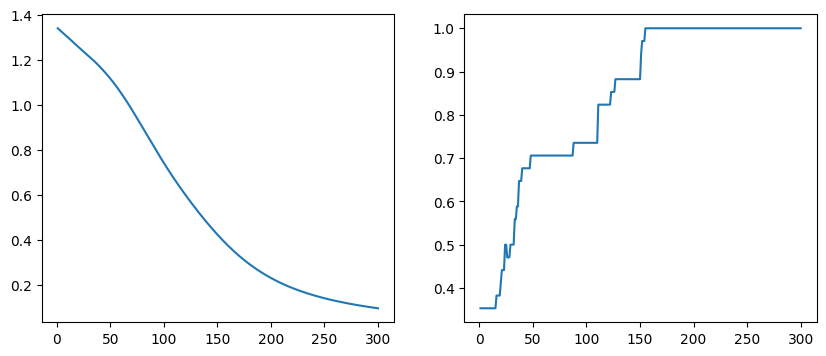

In [14]:
with torch.no_grad():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), losses)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), accuracies)

In [15]:
# ! pip install ffmpeg-python
from matplotlib import animation
from IPython.display import HTML

In [16]:
%%capture

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=2014),
        node_size=700,
        node_color=preds[i],
        cmap='cool',
        edge_color='grey',
        font_size=10
    )
    plt.title('Epoch %d: loss: %.2f, acc: %.2f%%' %\
              (i, losses[i], accuracies[i]*100))
    
fig = plt.figure(figsize=(7, 7))
plt.axis('off')

anim = animation.FuncAnimation(
    fig, animate,
    np.arange(0, num_epochs, display_freq),
    interval=1000,
    repeat=True)

html = HTML(anim.to_html5_video())

In [17]:
display(html)

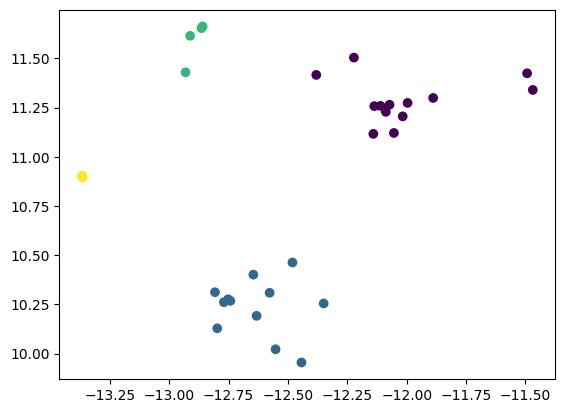

In [18]:
tsne = TSNE()
with torch.no_grad():
    embed2D = tsne.fit_transform(embeddings)

plt.scatter(embed2D[:, 0], embed2D[:, 1], c=preds[-1])

## Some fun

In [19]:
%%capture

rainbow_cmap = plt.cm.jet(np.linspace(0,1,300))

fig = plt.figure(figsize=(8, 4))
plt.axis('off')
plt.xlim([0, 300])
plt.ylim([-10, 20])

def animat(i):
    dx = 145
    dy = 10
    k = dy / dx**2

    x = np.linspace(i, i+1, 5)
    
    plt.plot(x, -k*((x-dx) ** 2) + dy + 5*np.sin(x**2) + np.random.normal(0, 0.3, len(x)), c=rainbow_cmap[i])

anim1 = animation.FuncAnimation(fig, animat, 300, interval=1000/144, repeat=True)

html = HTML(anim1.to_html5_video())

In [20]:
display(html)